# Natural Language Processing - final project

Il CTO ha fornito un dataset di email per realizzare le seguenti attività:
1. **Addestrare un classificatore** per identificare le email SPAM.
1. **Individuare i Topic principali** tra le email classificate come SPAM.
1. **Calcolare la distanza semantica** tra i topics ottenuti per valutare l'eterogeneità dei contenuti delle email SPAM.
1. **Estrarre dalle email NON SPAM** le informazioni sulle Organizzazioni menzionate.

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import spacy 
import nltk
from nltk.corpus import stopwords
from gensim.models import LdaMulticore, LdaModel
from sklearn.metrics import classification_report, roc_curve
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB
# from sklearn.naive_bayes import MultinomialNB
from pprint import pprint
from gensim.models import LdaMulticore
import gensim.corpora as corpora
import pyldavis.gensim


RANDOM_SEED = 176

ModuleNotFoundError: No module named 'pyldavis'

In [2]:

URL = "https://raw.githubusercontent.com/ProfAI/natural-language-processing/refs/heads/main/datasets/Verifica%20Finale%20-%20Spam%20Detection/spam_dataset.csv"

#import only useful columns
df = pd.read_csv(URL,usecols=["label","text","label_num"])
df.head()


,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\nthis deal is to ...,0


## Data exploration
In this section a descriptive analysis is performed, in order to investigate about dataset features.

### Missing values
Missing values should be handled somehow, if any.

In [3]:
df.isna().sum()

label        0
text         0
label_num    0
dtype: int64

Good news! Luckly there are no missing values.

### Label
First of all let's check `label` and `label_num` distribution; probably `label_num` has the same meaning of `label` but in an encoded fashion.

One can check it with univariate and multivariate analysis.

In [4]:
print(df["label"].value_counts())
print("-"*20)
print(df["label_num"].value_counts())

label
ham     3672
spam    1499
Name: count, dtype: int64
--------------------
label_num
0    3672
1    1499
Name: count, dtype: int64


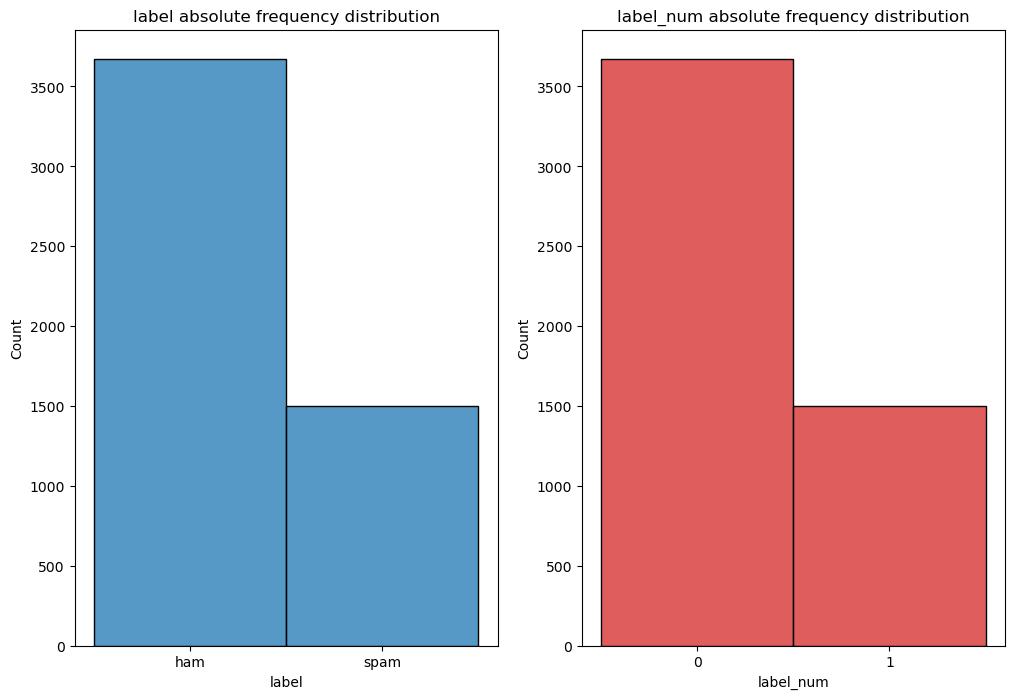

In [5]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
ax = sns.histplot(data=df, x="label",color="tab:blue")
plt.title("label absolute frequency distribution")
plt.subplot(1,2,2,sharey=ax)
sns.histplot(data=df, x="label_num", color="tab:red", discrete=True)
plt.xticks([0,1])
plt.title("label_num absolute frequency distribution")
plt.show()

As one can see - both from `value_counts` and histogram - the distribution of the two features seems to be identical. 

To be more even more confident about one can check if there are "hybrid" records, i.e. records where `label` and `label_num` values aren't one of the two pairs ("ham",0) or ("spam",1): to check it one can compute a bivariate histogram.

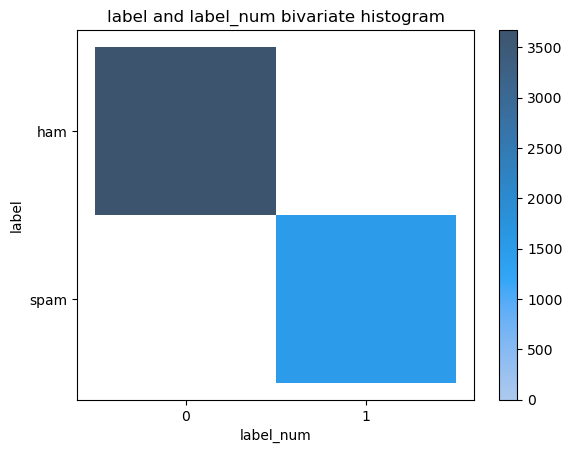

In [6]:
sns.histplot(data=df,x="label_num",y="label",discrete=(True,True),cbar=True)
plt.xticks([0,1])
plt.title("label and label_num bivariate histogram")
plt.show()

The histogram confirms the hypothesis: the two features have same meaning and can be used interchangeably.

In [7]:
print("Proportion between two lables:")
print(df["label"].value_counts(normalize=True))

Proportion between two lables:
label
ham     0.710114
spam    0.289886
Name: proportion, dtype: float64


As last comment about target distribution one sees that the two labels are imbalanced:

the _ham_ (negative) class is more represented than the _spam_ (positive) class ($71\%$ vs $29\%$)

### Text 
Regarding the `text` column, several comments will be shown in below sections, since the underlying information and data will be discovered through tools and models involved in next tasks.

## Text preprocessing
Before moving on with required tasks, a preprocessing must be done on text. With text a suitable preprocessing is crucial, since it helps models to better catch the data information, without getting confused about noise that is often present in a non-structured data like text. 

The preprocessing steps are:
1. Lowercase all the text
2. Remove punctuation
3. Remove english stopwords (taken from [nltk corpora data](https://www.nltk.org/nltk_data/))
4. Lemmatization (through the help of a pretrained model from [spacy lib](https://spacy.io/))
5. Remove numbers (**TODO: check if necessary**)

All these steps aim to get a lighter text (hence less memory required during models' training) without losing meaning-rich words.

In [8]:
# !python -m spacy download en_core_web_sm

In [9]:
nltk.download("stopwords")
stopwords_en = stopwords.words("english")

#inside stopwords include:
# - common words from email domain
stopwords_en.extend(["subject","cc","forwarded","fw"])
# - common words from url formatting and emails domains
stopwords_en.extend(["com","net","org","http","https","www"])
# - common html and css tags - TODO: necessary?
stopwords_en.extend(["html","htmlbody","div","tr","td","li","font","p","href"])

#nlp model from spacy
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aless\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def text_clean(sentence:str):
    #lowercase
    sentence = sentence.lower()

    #remove spaces around punctuation (ex: "orders @ amazon . com" becomes "orders@amazon.com")
    sentence = re.sub(r"\s+([._,;:!?\[\]@\(\)])\s+", r"\1", sentence)

    #remove email addresses
    sentence = re.sub(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}","",sentence)

    #punctuation
    for c in string.punctuation:
        sentence = sentence.replace(c, " ")
    
    #lemmatization
    doc = nlp(sentence)
    sentence = " ".join(token.lemma_ for token in doc)

    #stopwords - TODO: add "subject" and other words from email domain
    sentence = " ".join(word for word in sentence.split() if word not in stopwords_en)

    #remove numbers
    sentence = re.sub(r"\d","",sentence)

    #remove multiple spaces
    sentence = re.sub(r" +"," ",sentence)
    return sentence

In [11]:
regex = r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}"
email = "test@example.com,email@email.com"
# email = "test"
# re.match(regex, email) is not None
re.sub(regex,"",email)

','

In [12]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
text = "orders @ amazon . com / "
# text = "orders@amazon.com"
text = "ect @ ect , jim fallon / hou / ect @ ect"
re.sub(r"\s+([._,;:!?\[\]@\(\)])\s+", r"\1", text)

'ect@ect,jim fallon / hou / ect@ect'

In [14]:
df["text_clean"] = df["text"].apply(text_clean)

df.head(10)

,label,text,label_num,text_clean
0,ham,Subject: enron methanol ; meter # : 988291\nth...,0,enron methanol meter follow note I give monday...
1,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0,hpl nom january see attach file hplnol xls hpl...
2,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0,neon retreat ho ho ho around wonderful time ye...
3,spam,"Subject: photoshop , windows , office . cheap ...",1,photoshop window office cheap main trending ab...
4,ham,Subject: re : indian springs\nthis deal is to ...,0,indian spring deal book teco pvr revenue under...
5,ham,Subject: ehronline web address change\nthis me...,0,ehronline web address change message intend eh...
6,ham,Subject: spring savings certificate - take 30 ...,0,spring saving certificate take save use custom...
7,spam,Subject: looking for medication ? we ` re the ...,1,look medication good source difficult make mat...
8,ham,Subject: noms / actual flow for 2 / 26\nwe agr...,0,nom actual flow agree forward melissa jones te...
9,ham,"Subject: nominations for oct . 21 - 23 , 2000\...",0,nomination oct see attach file hplnl xls hplnl...


Let's visualize the difference between raw text adn clean text in terms of string lenght: this way one can check how "dirty" was the raw text.

In [15]:
raw_text_len = df["text"].apply(len)
clean_text_len = df["text_clean"].apply(len)

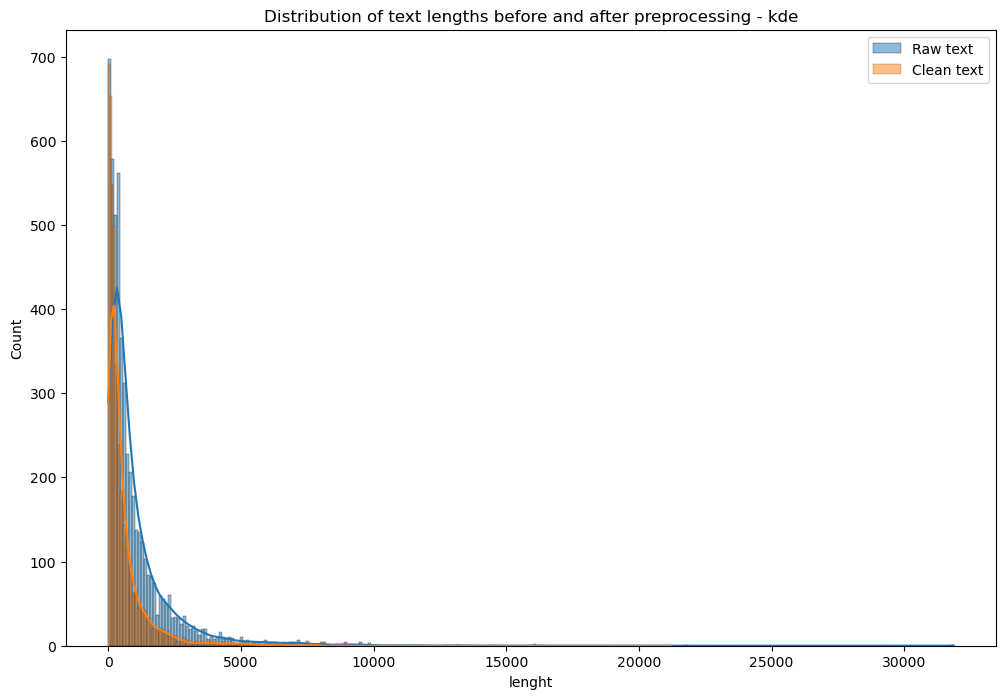

In [16]:
plt.figure(figsize=(12,8))
sns.histplot(x=raw_text_len,kde=True,label="Raw text")
sns.histplot(x=clean_text_len,kde=True,label="Clean text")
plt.legend()
plt.xlabel("lenght")
plt.title("Distribution of text lengths before and after preprocessing - kde")
plt.show()

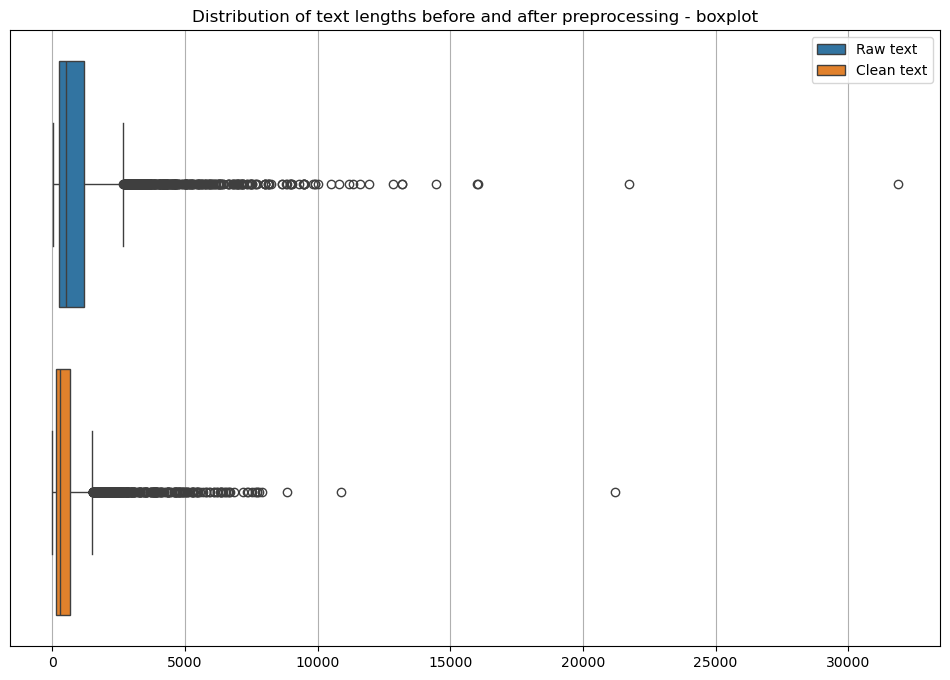

In [17]:
plt.figure(figsize=(12,8))
sns.boxplot(data=[raw_text_len.values, clean_text_len.values], orient="h")
plt.legend(["Raw text","Clean text"])
plt.title('Distribution of text lengths before and after preprocessing - boxplot')
plt.yticks([])
plt.gca().grid(True)
plt.show()

In [18]:
print("Text lenght summary stats:")
#define a temporary dataframe only for visualization purposes
pd.DataFrame([raw_text_len.describe(),clean_text_len.describe()])

Text lenght summary stats:


,count,mean,std,min,25%,50%,75%,max
text,5171.0,1029.745310,1505.103170,10.0,238.0,529.0,1214.0,31860.0
text_clean,5171.0,605.303616,954.100905,0.0,125.0,292.0,680.5,21224.0


The above charts and dataframe show as the preprocessing was really effective: after cleaning the lenght distribution is shifted towards left (i.e. mean value decreases) and it's more "compressed" (i.e. standard deviation decreases); in other words, several meaningless words and character have been removed (in the most extreme case there is a lenght difference greater than 10k characters!), and this will lead to a lighter model, less affected by noise.

Although the text cleaning is useful, one should note that now there is at least one record with 0 lenght: the minimum lenght value decreases from 10 to 0 after cleaning.

This means that in the original dataset there are records made up of only stopwords or punctuation; it's advisable remove such records, since a string with no characters bring no information. 

According to IQR method there are a lot of outliers in lenght distribution, both before and after cleaning (see dots in boxplots) but without further information about email lenght limits, these data points cannot be considered anomalous, so they're kept as is.


In [19]:
#remove 0 length texts
print(f"There are {(clean_text_len==0).sum()} records with 0 lenght after preprocessing")

df = df[clean_text_len != 0]

#check
df.shape

There are 18 records with 0 lenght after preprocessing


(5153, 4)

## Classification ham - spam

Che classificatore ci metto? 
Bayes?
RNN (e quindi lo sbatti del deep learning)?
Multi layer perceptron?
Altri??

Se uso un approccio bow, il bayesiano viene automatico... O volendo anche la rete neurale (MLP), ma gli altri non molto...
Se uso un embedding, tanto vale usare l'embedding di keras e quindi passare direttamente a rete neurale... Ma non sarà troppa roba con anche le altre cose di mezzo?

Seguiamo approccio semplice e usiamo BOW (da decidere se con tf-idf o count vectorizer) e bayesiano (viva occam).

In [20]:
X = df["text_clean"].values
# y = df["label_num"].values
y = df["label"].values

X_train, X_test, y_train,y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_SEED)

#check
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(4122,)
(1031,)
(4122,)
(1031,)


### Classification Model
A naive bayesian classifier here is used, precisely here a [Complement Naive Bayes classifier](https://scikit-learn.org/stable/modules/naive_bayes.html#complement-naive-bayes) is used.

As common practice, the text is vectorized using a traditional Bag Of Words approach, through `sklearn` [CountVecorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), i.e. feature space has dimensionality equal to built vocabulary and i-th feature is the i-th word (absolute) occurence frequency.

The "standard" Bayes model used in text classification is the [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes), but with imbalanced datasets the Complement Naive Bayes is more suitable (the assumptions about features distributions is the same in both models). 


In [21]:
#vectorizer
vectorizer = CountVectorizer(min_df=0.04) #to avoid curse of dimensionality, include only words with relative frequency >= 4%
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

#check
print(X_train.shape)
print(X_test.shape)

(4122, 209)
(1031, 209)


In [22]:
model = ComplementNB()

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         ham       0.96      0.87      0.92       735
        spam       0.75      0.92      0.82       296

    accuracy                           0.89      1031
   macro avg       0.85      0.90      0.87      1031
weighted avg       0.90      0.89      0.89      1031



In [23]:
y_pred_prob_test = model.predict_proba(X_test)

Best threshold: 0.5


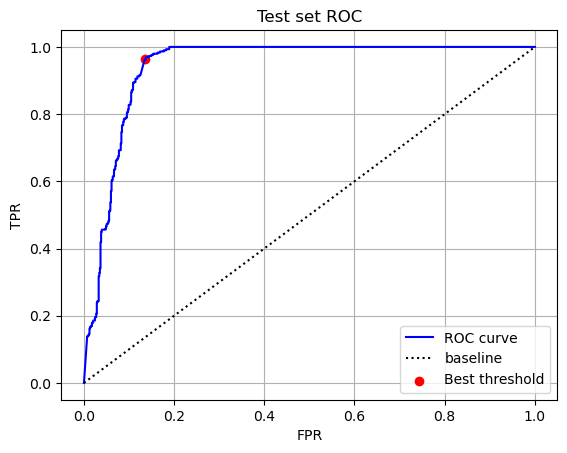

In [24]:
#positive class scores are y_pred_prob_test[:,1] because positive class is
#in second position between model's classes 
#(you can check with model.classes_)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_test[:,1], 
                                         pos_label="spam",
                                 drop_intermediate=False)
plt.figure()
plt.plot(fpr,tpr,'-b', label="ROC curve")
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),':k',label="baseline")
plt.grid()
plt.title("Test set ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")

#this section is explained below the chart
#Euclidean distances between each ROC point and (0,1) point
distances = np.sqrt((1-tpr)**2 + fpr**2)

# find point with minimum distance from (0,1)
index = np.argmin(distances)
#and the corrsponding threshold
best_threshold = thresholds[index]

print(f"Best threshold: {best_threshold}")
plt.scatter(fpr[index],tpr[index],c="r",label="Best threshold")
plt.legend()
plt.show()

In [25]:
y_pred_test  = np.where(y_pred_prob_test[:,1]>=best_threshold,"spam","ham")

print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

         ham       0.98      0.87      0.92       735
        spam       0.74      0.96      0.84       296

    accuracy                           0.89      1031
   macro avg       0.86      0.91      0.88      1031
weighted avg       0.91      0.89      0.90      1031



In [26]:
# from sklearn.naive_bayes import MultinomialNB
# model2 = MultinomialNB()

# model2.fit(X_train,y_train)
# y_pred2 = model2.predict(X_test)

# print(classification_report(y_test,y_pred2))

### Classify whole dataset
This step is useful for next tasks; here the whole dataset is classified as spam or ham, and the collections of the two predictions are stored in utility variables.

In [27]:
#classify whole dataset (i.e. X variable)
X_vectorized = vectorizer.transform(X)
predictions_proba = model.predict_proba(X_vectorized)
predictions  = np.where(predictions_proba[:,1]>=best_threshold,"spam","ham")

ham_predictions = X[predictions == 'ham']
spam_predictions = X[predictions == 'spam']

#check
print(ham_predictions.shape) #3672 - 3369
print(spam_predictions.shape) #1499 - 1784

(3260,)
(1893,)


In [28]:
print(classification_report(y,predictions))

              precision    recall  f1-score   support

         ham       0.99      0.88      0.93      3672
        spam       0.76      0.97      0.85      1481

    accuracy                           0.90      5153
   macro avg       0.87      0.93      0.89      5153
weighted avg       0.92      0.90      0.91      5153



In [29]:
# from sklearn.metrics import RocCurveDisplay

# RocCurveDisplay.from_estimator(model, X_vectorized, y)
# plt.show()

## Topic modeling 
Using emails classified as _spam_ the main topics are detected with LDA (Latent Dirichlet Allocation) technique.

This technique performs a sort of clustering of documents (here documents = emails), where each cluster contains documents with same topic. 

Key difference between this technique and kmeans (another famous clusteing method) is that LDA uses a statistical approach, and a document can be made up of more than one topic (i.e. a document can appear in more than one topic cluster).


According to this technique the documents are made up of topics and topics are made up of words, each of them with some probability distribution.

These distributions can be modeled through two matrices:
- $\Delta$ with dimensions $d \times k$, where each row $\delta_i$ is the topic distribution for document $i$ (i.e. $\Delta_{ij}$ is the probability that document $i$ has topic $j$).
- $\Phi$ with dimensions $w \times k$, where each row $\varphi_i$ is the topic distribution for word $i$ (i.e. $\Phi_{ij}$ is the probability that word $i$ belongs to topic $j$).

**If a word w has high probability of being in a topic, all the documents having w will be more strongly associated with t as well.**

The aim of LDA is to compute these two matrices (or in statistical terms to model all the probability distributions), using iterative techniques like [Monte Carlo simulation or Gibbs sampling](https://www.wikiwand.com/en/articles/Latent_Dirichlet_allocation).

The model itself doesn't provide topic name or meaning, but it must be inferred manually, considering keywords of computed clusters.

LDA is implemented in `gensim` lib.

For further deatils about LDA:
- [Towards Data Science blog](https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2)

In [30]:
spam_predictions.shape

(1893,)

In [31]:
spam_words = [s.split() for s in spam_predictions]

id2word = corpora.Dictionary(spam_words) #dictionary of spam predictions
corpus = [id2word.doc2bow(text) for text in spam_words]

#check: if everything is fine spam_predictions lenght and corpus lenght must be the same
print(len(spam_predictions))
print(len(corpus))

1893
1893


### LDA model hyperparameters

In LDA there in a crucial hyperparameter:  $n_{topics}$, i.e. the number of topics inside corpus.

If $n_{topics}$ is too low the model will find too general topics, not much informative (the model is too general and simple), while if $n_{topics}$ is too high data will be fragmented a lot and topics will be too specific and hard to interpret (the model is too specific and can't generalize, a.k.a. overfitting); conceptually this is very similar to the $k$ value used in _kmeans_ clustering.

As proposed in [this kaggle notebook](https://www.kaggle.com/code/parthplc/topic-modeling-using-lda), a common approach to find the optimal $n_{topics}$ value is to use an elbow method on perplexity.

Considering that a NLP model is a probability distribution over sentences, [perplexity is a good metrics to evaluate it](https://medium.com/nlplanet/two-minutes-nlp-perplexity-explained-with-simple-probabilities-6cdc46884584): perplexity is defined as the uncertainity in a value prediction from a probability distribution, or in other words in NLP context [it measures the model's ability in predict a word](https://klu.ai/glossary/perplexity) (and thus a topic) in a sentence (in topic modeling predict = assign probabilities). 

In general:
- Low perplexity score means high confidence and accuracy in predictions.
- High perplexity score means less realiable predictions, with higher "surprise" when encountering new data (model has more difficulty in predictions).

In information theory [perplexity is related to Shannon Entropy](https://www.wikiwand.com/en/articles/Perplexity) and it can be computed as:

$ PP(p) = 2^{H(p)} = 2^{-\sum_{x}p(x)log_{2}p(x)} $ 

Perplexity metrics can be computed via `log_perplexity` method of `LdaModel` class.



In [47]:
# Funzione per calcolare la perplessità per diversi numeri di topic
def compute_perplexity(corpus, dictionary, num_topics):
    lda_model = LdaMulticore(corpus = corpus, 
                             num_topics = num_topics, 
                             id2word=dictionary, 
                             passes = 5, 
                             minimum_probability = 0.05,
                             random_state = RANDOM_SEED)
    return 2**(-lda_model.log_perplexity(corpus))

464.4853238888819
454.55455083014283
440.2715700129014
448.2310697783275
442.0139758518807
427.7510333058003
424.4612319323117
429.439553716104
426.9663048722467


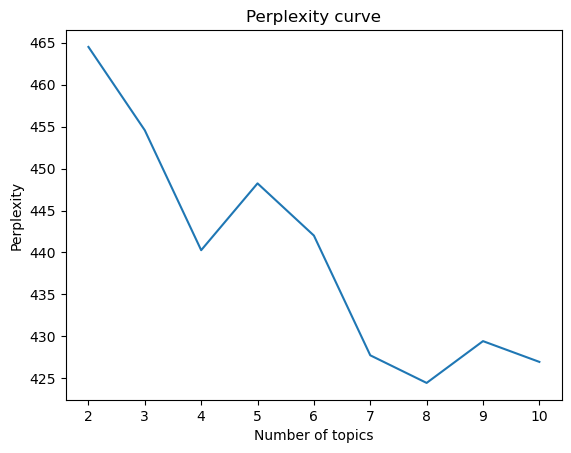

In [48]:
# Lista di numeri di topic da testare
num_topics_list = range(2, 11)  # Ad esempio, da 2 a 10 topic

# Calcolo della perplessità per ogni numero di topic
perplexities = []
for num_topics in num_topics_list:
    perplexity = compute_perplexity(corpus, id2word, num_topics)
    print(perplexity)
    perplexities.append(perplexity)

# Creazione del grafico
plt.plot(num_topics_list, perplexities)
plt.xlabel('Number of topics')
plt.ylabel('Perplexity')
plt.title('Perplexity curve')
plt.show()

The curve isn't an ideal curve since it hasn't a monotonous decreasing trend; however it seems to have a decreasing behaviour.

It seems that after $n_{topiccs} = 4$ the curve tends to decrease more slowly, hence we can consider this value as our optimal number of topics, according toe the curve.

However one should always keep in mind the domain knowledge, that is spam emails: usually these emails don't contain a wide variety of topics, but they tend to talk about few topics (like some offers for purchase a product, some request of be contacted, some proposal of investment and something related to dating and sex topics), hence the value 4 is perfectly suitable for our scope, but just for curiosity we can try even with 3 topics, considering that our curve isn't so stable and 3 is a reasonable value too (values below 3 are too few, while values greater than 4 are excluded cause of the above chart). 

Gensims offers a utils tool to better visualize model and clustering via `pyLDAvis`: agreeing with [neptune ai blog](https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know) this tool makes a bubble chart of topics clusters (that are mapped through a 2 components PCA) where the bubble size is proportional to the numbers of docs belonging to that topic; on the right side there is an interactive histogram where the blue bars represent the overall frequency of each word in the corpus, while red bars give the estimated number of times a given term was generated by a given topic.

### Final LDA model(s)

In [55]:
num_topics = 4

lda_model_4_topics = LdaMulticore(corpus = corpus,
                         id2word=id2word,
                         num_topics=num_topics,
                         passes = 5, 
                         minimum_probability = 0.05,
                         random_state=RANDOM_SEED)

In [56]:
pprint(lda_model_4_topics.print_topics(num_words=20, num_topics=-1))

[(0,
  '0.007*"price" + 0.004*"adobe" + 0.003*"xp" + 0.003*"microsoft" + '
  '0.003*"window" + 0.003*"cd" + 0.003*"software" + 0.003*"professional" + '
  '0.003*"office" + 0.002*"order" + 0.002*"e" + 0.002*"use" + 0.002*"I" + '
  '0.002*"service" + 0.002*"pro" + 0.002*"ms" + 0.002*"information" + '
  '0.002*"system" + 0.002*"need" + 0.002*"new"'),
 (1,
  '0.014*"I" + 0.010*"company" + 0.005*"statement" + 0.004*"stock" + '
  '0.004*"information" + 0.004*"height" + 0.004*"may" + 0.004*"security" + '
  '0.003*"price" + 0.003*"investment" + 0.003*"report" + 0.003*"width" + '
  '0.003*"within" + 0.003*"make" + 0.003*"go" + 0.003*"time" + 0.003*"get" + '
  '0.003*"business" + 0.003*"use" + 0.003*"look"'),
 (2,
  '0.008*"nbsp" + 0.007*"pill" + 0.005*"e" + 0.004*"mail" + 0.003*"I" + '
  '0.003*"email" + 0.003*"br" + 0.003*"get" + 0.002*"color" + 0.002*"number" + '
  '0.002*"please" + 0.002*"mg" + 0.002*"c" + 0.002*"information" + '
  '0.002*"want" + 0.002*"send" + 0.002*"b" + 0.002*"face" + 0.

In [57]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_4_topics, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.047793 -0.099343       1        1  39.507640
1      0.088695  0.057381       2        1  35.291588
0     -0.108726 -0.010170       3        1  12.642628
2     -0.027762  0.052132       4        1  12.558145, topic_info=          Term        Freq       Total Category  logprob  loglift
3021      nbsp  303.000000  303.000000  Default  30.0000  30.0000
309       pill  265.000000  265.000000  Default  29.0000  29.0000
381    company  897.000000  897.000000  Default  28.0000  28.0000
246      price  752.000000  752.000000  Default  27.0000  27.0000
11309   height  329.000000  329.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
294       good   42.321983  451.920091   Topic4  -6.4871  -0.2934
239        new   43.021848  675.161960   Topic4  -6.4707  -0.6784
122       time   42.347852  650.307323   Topic4  -6.4865  -0.6567
1986      size   38.464132  278.876298   Topic4  -6.5827   0.0938
381    company   38.475387  897.844023   Topic4  -6.5824  -1.0752

[368 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.543681          I
0         2  0.400723          I
0         3  0.023400          I
0         4  0.032540          I
2591      4  0.880407  abdominal
...     ...       ...        ...
6841      4  0.893610   zanaflex
6842      4  0.893713    zebutal
1425      1  0.966917  zonedubai
1425      2  0.026859  zonedubai
1425      3  0.026859  zonedubai

[939 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

Try with 3 topics

In [58]:
num_topics = 3

lda_model_3_topics = LdaMulticore(corpus = corpus,
                         id2word=id2word,
                         num_topics=num_topics,
                         passes = 5, 
                         minimum_probability = 0.05,
                         random_state=RANDOM_SEED)

In [59]:
pprint(lda_model_3_topics.print_topics(num_words=20, num_topics=-1))

[(0,
  '0.006*"price" + 0.006*"I" + 0.005*"e" + 0.005*"please" + 0.004*"order" + '
  '0.003*"product" + 0.003*"use" + 0.003*"message" + 0.003*"computron" + '
  '0.003*"contact" + 0.003*"new" + 0.003*"mail" + 0.003*"click" + '
  '0.003*"information" + 0.002*"list" + 0.002*"microsoft" + 0.002*"need" + '
  '0.002*"change" + 0.002*"u" + 0.002*"send"'),
 (1,
  '0.018*"I" + 0.007*"company" + 0.005*"get" + 0.004*"statement" + '
  '0.004*"time" + 0.003*"information" + 0.003*"stock" + 0.003*"please" + '
  '0.003*"go" + 0.003*"make" + 0.003*"may" + 0.003*"new" + 0.003*"email" + '
  '0.003*"height" + 0.003*"price" + 0.003*"know" + 0.003*"one" + '
  '0.003*"security" + 0.003*"look" + 0.002*"report"'),
 (2,
  '0.006*"e" + 0.006*"nbsp" + 0.005*"pill" + 0.004*"I" + 0.004*"mail" + '
  '0.004*"get" + 0.004*"email" + 0.003*"please" + 0.003*"c" + 0.003*"new" + '
  '0.002*"r" + 0.002*"good" + 0.002*"message" + 0.002*"send" + 0.002*"number" '
  '+ 0.002*"n" + 0.002*"want" + 0.002*"br" + 0.002*"offer" + 0.0

In [60]:
pyLDAvis.gensim.prepare(lda_model_3_topics, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.094174 -0.009680       1        1  52.887793
0      0.056653 -0.066628       2        1  27.618104
2      0.037520  0.076308       3        1  19.494103, topic_info=             Term        Freq       Total Category  logprob  loglift
3021         nbsp  326.000000  326.000000  Default  30.0000  30.0000
309          pill  273.000000  273.000000  Default  29.0000  29.0000
210             e  765.000000  765.000000  Default  28.0000  28.0000
1296    computron  196.000000  196.000000  Default  27.0000  27.0000
246         price  766.000000  766.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1223      address   64.159333  268.371287   Topic3  -6.5108   0.2041
470           may   73.777024  533.915661   Topic3  -6.3711  -0.3441
122          time   76.180092  635.105519   Topic3  -6.3391  -0.4856
301          look   68.787134  418.540341   Topic3  -6.4411  -0.1707
442   information   72.971230  628.898079   Topic3  -6.3821  -0.5188

[287 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.797070          I
0         2  0.132349          I
0         3  0.070636          I
2591      3  0.926221  abdominal
335       1  0.854568        act
...     ...       ...        ...
1531      3  0.051799         xp
6842      3  0.833522    zebutal
1425      1  0.032458  zonedubai
1425      2  0.908824  zonedubai
1425      3  0.032458  zonedubai

[599 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

### Comments about detected topics

Both models performs quite good, with clusters well separated (see the two intertopic maps); it seems that in model with 4 topics the topic n. 1 of the other model is splitted into 2 topics (in fact one sees that bubbles of topic 2 anad 3 of second model are likely in same position of topic 1 and 2 of first model).

Considering the words-per-topic distributions, the model with 4 topics is more suitable, since detected topics are more human understadable:
- Topic 1 is about a phishing attempt, in fact here there are words like _order_, _message_, _free_, _product_. _email_, _offer_.
- Topic 2 is probably about trading scam, since here there are words usually used by such scammers like _business_, _investment_, _information_, _stock_, _company_, _time_, _please_, _report_ (trade scammers have rush to complete the scam and for this reason they're often kind, [but they tends to make the victim full of proud focusing only on winning strategies](https://disb.dc.gov/page/beware-other-people%E2%80%99s-money-investment-scams))
- Topic 3 is about malware attack and/or software service fake offer (however a [software scam](https://fraud.org/malware/)): here there are the most common softwares names and related companies, like _microsoft_, _office_ (think about Microsoft Office suite), _software_, _xp_, _photoshop_ and more general words related to a download operation like _server_ and _download_ itself.
- Topic 4 is likely a dating spam/scam, in fact here there are one character words and acronym that are mostly used in informal context (like dating) and other words related to meeting irl: _address_, _pill_, _number_, _face_, _nbsp_ (that probably here is not the html tag, [but more likely "No Bullsh*t Please."](https://www.thoughtco.com/what-does-nbsp-mean-4691029).

Note: this bullet list has been done using enumeration given by bubble chart and not by the `print_topics` function).

## Semantic distance in SPAM emails
Bisogna usare la distanza coseno tra le coppie di frasi, cioè calcolare l'embedding medio di ogni frase e poi calcolare la distanza tra questi vettori medi.

Basati su quanto fatto nelle esercitazioni, il task è molto simile.

## Organizations in HAM emails
Bisogna fare il NER. Usa spacy per farlo e te ne esci pulito. 

Bisogna fare un filtraggio di tutti i NER ottenuti per prendere solo quelli col tag 'ORG'.